In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv', index_col='index')
data

/var/folders/wc/rqgqs2ld2v9_r289z6535cx80000gn/T/ipykernel_54310/2107371522.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,time,level,long,lat
index,,,,
2023-12,0,0,-0.130495,51.511534
2023-12,1,0,-0.140844,51.514684
2023-12,2,0,-0.135874,51.515684
2023-12,3,0,-0.110329,51.518250
2023-12,4,0,-0.125708,51.507725
...,...,...,...,...
2023-12,8953,1,-0.134599,51.511608
2023-12,8954,1,-0.125331,51.513753
2023-12,8955,1,-0.131706,51.509404


/Users/zhenglongwu/Documents/GitHub/Three-Sigma/.venv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/misc.py:457: RuntimeWarning: invalid value encountered in scalar divide
  return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / n / c0


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

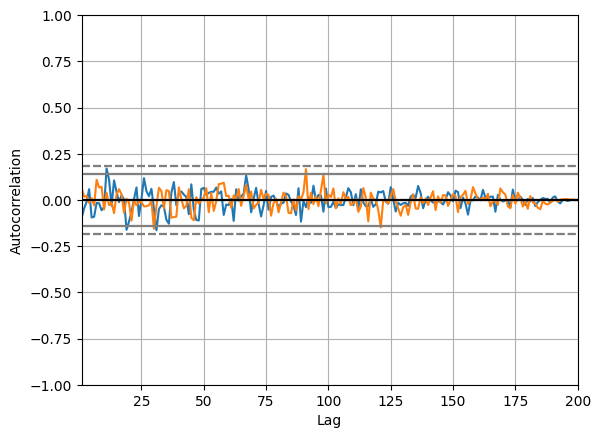

In [2]:
pd.plotting.autocorrelation_plot(data['long'][:200])
pd.plotting.autocorrelation_plot(data['lat'][:200])
pd.plotting.autocorrelation_plot(data['level'][:200])

In [31]:
import tensorflow as tf
from keras_tuner.tuners import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

X = scaled_data[:, 1:]  # Features long, lat, and time, level
y = scaled_data[:, :3]  # Targets level, long, lat

X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [4]:
def build_model(hp):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[2, 3, 4]),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        input_shape=(X_train.shape[1], 1)))

    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    model.add(tf.keras.layers.LSTM(
        units=hp.Int('units', min_value=30, max_value=100, step=10), 
        activation='relu'))

    model.add(tf.keras.layers.Dense(3))

    model.compile(optimizer='adam', loss='mse')
    return model

In [8]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss', 
    max_trials=5,     
    executions_per_trial=2,
    directory='new_optimise_logs', 
    project_name='keras_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 00s]

Best val_loss So Far: 0.010927499271929264
Total elapsed time: 00h 00m 08s


In [11]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

best_model.evaluate(X_test, y_test)

Epoch 1/50
224/224 [==============================] - 1s 2ms/step - loss: 0.0625 - val_loss: 0.0134
Epoch 2/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 3/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 4/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 5/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 6/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0109
Epoch 7/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 8/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 9/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 10/50
224/224 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0110

0.010567634366452694

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

predictions = best_model.predict(X_test)

56/56 [==============================] - 0s 585us/step


In [13]:
mse_level = mean_squared_error(y_test[:, 0], predictions[:, 0])
rmse_level = np.sqrt(mse_level)
mae_level = mean_absolute_error(y_test[:, 0], predictions[:, 0])

mse_long = mean_squared_error(y_test[:, 1], predictions[:, 1])
rmse_long = np.sqrt(mse_long)
mae_long = mean_absolute_error(y_test[:, 1], predictions[:, 1])

mse_lat = mean_squared_error(y_test[:, 2], predictions[:, 2])
rmse_lat = np.sqrt(mse_lat)
mae_lat = mean_absolute_error(y_test[:, 2], predictions[:, 2])

print("Crime Level - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_level, rmse_level, mae_level))
print("Longitude - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_long, rmse_long, mae_long))
print("Latitude - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_lat, rmse_lat, mae_lat))

Crime Level - MSE: 0.0316, RMSE: 0.1777, MAE: 0.1381
Longitude - MSE: 0.0001, RMSE: 0.0095, MAE: 0.0068
Latitude - MSE: 0.0001, RMSE: 0.0072, MAE: 0.0044


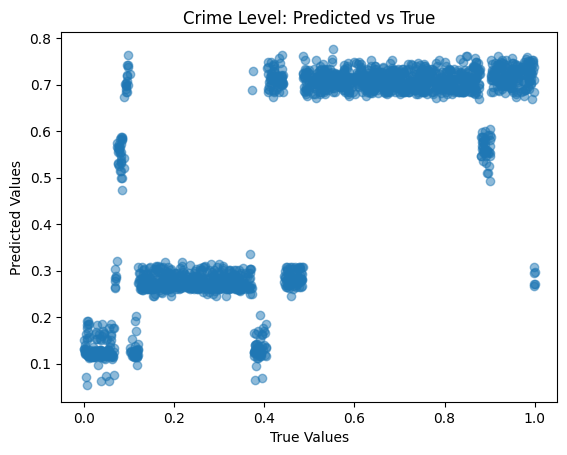

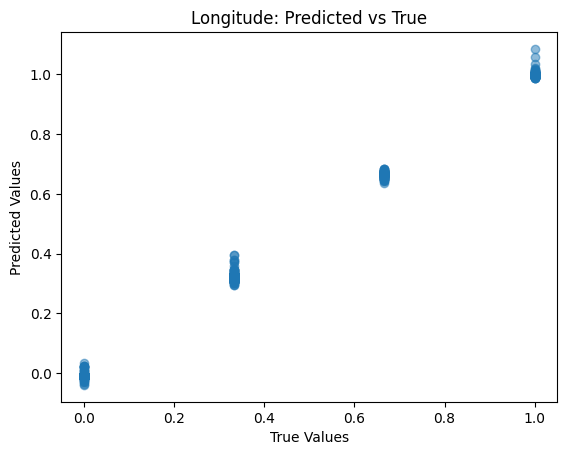

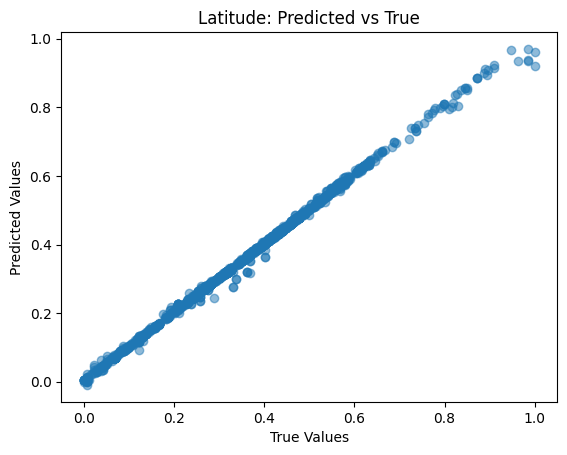

In [35]:
import matplotlib.pyplot as plt

# Crime Level
plt.scatter(y_test[:, 0], predictions[:, 0], alpha=0.5)
plt.title("Crime Level: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Longitude
plt.scatter(y_test[:, 1], predictions[:, 1], alpha=0.5)
plt.title("Longitude: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

# Latitude
plt.scatter(y_test[:, 2], predictions[:, 2], alpha=0.5)
plt.title("Latitude: Predicted vs True")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

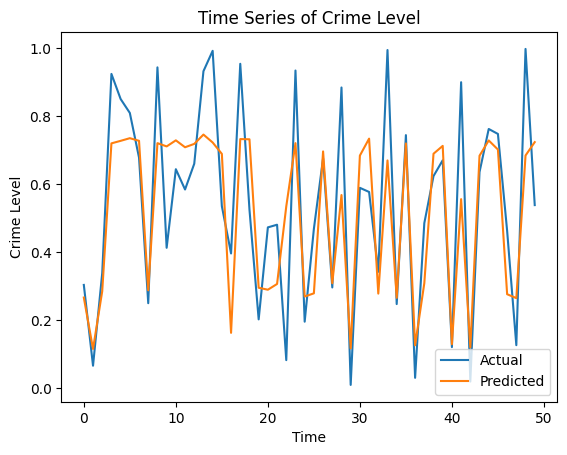

In [38]:
time_variable = np.arange(len(y_test)) 

plt.plot(time_variable[:50], y_test[:, 0][:50], label='Actual')
plt.plot(time_variable[:50], predictions[:, 0][:50], label='Predicted')
plt.title('Time Series of Crime Level')
plt.xlabel('Time')
plt.ylabel('Crime Level')
plt.legend()
plt.show()

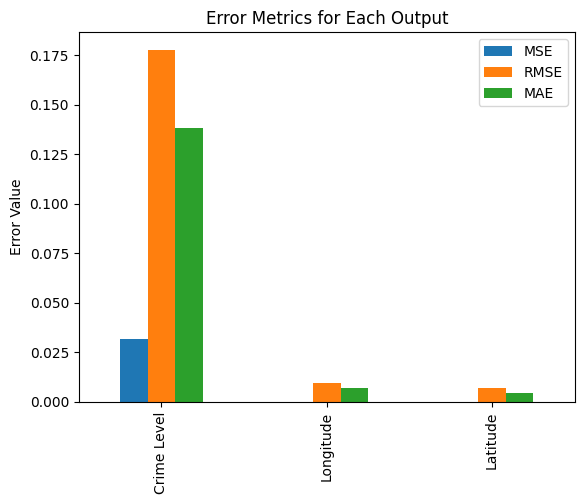

In [16]:
error_metrics = {'MSE': [mse_level, mse_long, mse_lat],
                 'RMSE': [rmse_level, rmse_long, rmse_lat],
                 'MAE': [mae_level, mae_long, mae_lat]}

import pandas as pd
df_errors = pd.DataFrame(error_metrics, index=['Crime Level', 'Longitude', 'Latitude'])

# Plotting
df_errors.plot(kind='bar')
plt.title('Error Metrics for Each Output')
plt.ylabel('Error Value')
plt.show()